# Plot time series of speed, PDDs, and terminus retreat, fit linear models to peaks 

In [3]:
import xarray as xr
import rioxarray as rxr
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import geopandas as gpd
import scipy
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.signal import detrend

## Load datasets

Velocities loaded
Weather loaded
Terminus sections loaded
Terminus positions loaded


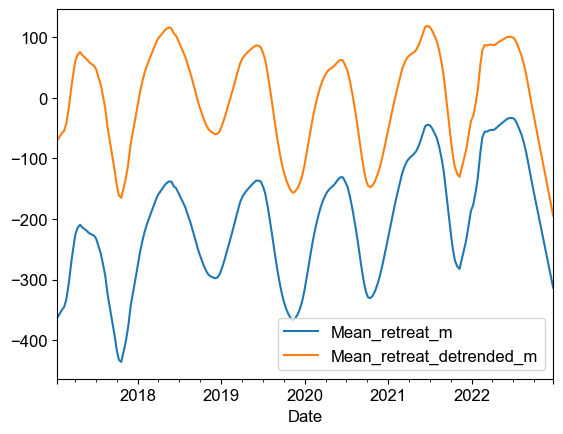

In [19]:
data_path = '/Users/raineyaberle/Research/Hubbard/'
out_path = '/Users/raineyaberle/Research/Hubbard/figures/'
crs = 'EPSG:3338'

# -----Velocity
ds_fn = os.path.join(data_path, 'velocity', 'Hubbard_S1.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject(crs)
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)
ds = ds.rio.write_crs(crs)
print('Velocities loaded')

# -----Air temperature --> PDDs
air_fn = os.path.join(data_path, 'weather', 'Yakutat_2000_2023.csv')
air = pd.read_csv(air_fn)
# remove empty columns
air = air[[x for x in list(air.columns) if 'Unnamed' not in x]]
air['Date_Time'] = pd.DatetimeIndex(air['Date_Time'])
air.rename(columns={'Date_Time': 'Date'}, inplace=True)
print('Weather loaded')

# -----Terminus sections
term_sect_fn = os.path.join(data_path, 'terminus', 'terminus_sections.gpkg')
term_sect = gpd.read_file(term_sect_fn)
term_sect = term_sect.to_crs(crs)
print('Terminus sections loaded')

# -----Terminus
term_fn = os.path.join(data_path, 'terminus', 'terminus_speed_weather.csv')
term = pd.read_csv(term_fn)
term['Date'] = pd.to_datetime(term['Date'])
term.drop_duplicates(inplace=True)
# Calculate the negative to measure retreat as positive
term['Mean_retreat_m'] = -term['terminus_advance_m']
# Resample to daily
term.set_index('Date', inplace=True)
term = term.resample('1D').interpolate('time')
term.reset_index(inplace=True)
# Detrend terminus retreat
term['Mean_retreat_detrended_m'] = detrend(term['Mean_retreat_m'])
term.set_index('Date')[['Mean_retreat_m', 'Mean_retreat_detrended_m']].plot()
print('Terminus positions loaded')


In [40]:
term

,Date,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,surface_speed_m_per_yr,terminus_advance_m,Mean_retreat_m,Mean_retreat_detrended_m,fake_year
0,2017-01-13,1.360870,0.706522,3.028502,0.003556,1.360870,0.706522,3.028502,1.130423,2225.262216,363.547945,-363.547945,-70.103902,2016
1,2017-01-14,1.673118,0.976344,3.667391,0.069088,1.673118,0.976344,3.667391,1.103321,2239.297061,362.915180,-362.915180,-69.551515,2016
2,2017-01-15,1.703297,0.995604,2.999580,0.051054,1.703297,0.995604,2.999580,1.076603,2253.331905,362.282415,-362.282415,-68.999128,2016
3,2017-01-16,2.396703,1.710989,3.036864,0.028702,2.396703,1.710989,3.036864,1.050198,2267.366750,361.649650,-361.649650,-68.446741,2016
4,2017-01-17,0.417778,-0.348889,-1.948101,0.037084,0.417778,0.000000,0.000000,1.024056,2281.401594,361.016885,-361.016885,-67.894354,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2022-12-19,7.500000,7.100000,-4.262250,0.009398,7.500000,7.100000,0.000000,0.388942,987.388939,306.353608,-306.353608,-187.008488,2022
2167,2022-12-20,7.500000,7.100000,-5.629377,0.000762,7.500000,7.100000,0.000000,0.311713,1003.322547,308.251402,-308.251402,-188.986660,2022
2168,2022-12-21,7.500000,7.100000,-4.772812,0.004064,7.500000,7.100000,0.000000,0.234786,1019.256155,310.149195,-310.149195,-190.964831,2022
2169,2022-12-22,7.500000,7.100000,-11.792258,0.004318,7.500000,7.100000,0.000000,0.158157,1035.189763,312.046988,-312.046988,-192.943003,2022


## Sample speeds at each terminus section, average

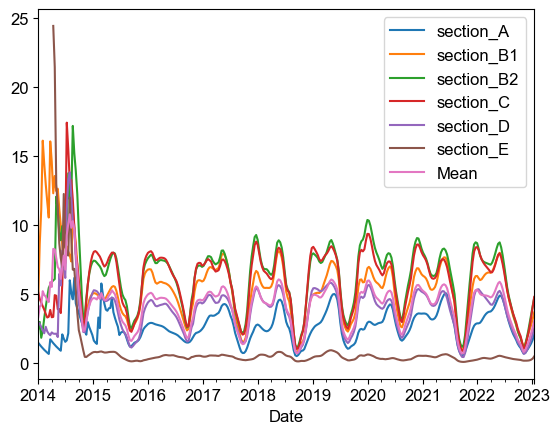

In [20]:
# Calculate mean speeds in each section
v_term = pd.DataFrame(columns=['Date'] + list(term_sect['section'].values))
v_term['Date'] = ds.time.data
for i in range(0,len(term_sect)):
    term_sect_i = term_sect.iloc[i,:]
    # Clip velocity to terminus section
    v_samp = ds.rio.clip([term_sect_i.geometry])
    # Average the timeseries in the polygon
    v_samp_mean = v_samp.mean(dim='x').mean(dim='y').v.data
    # Add to dataframe
    v_term[term_sect_i['section']] = v_samp_mean

# Calculate mean time series in all terminus sections
v_term.set_index('Date', inplace=True)
v_term['Mean'] = v_term.mean(axis=1)
v_term = v_term / 365 # Convert from m/y to m/d
v_term.plot()
v_term.reset_index(inplace=True)

In [61]:
## Calculate annual peaks
# Add fake year columns (starting in April)
def add_fake_year_column(df):
    def calculate_fake_year(month, year):
        if month < 4:
            return year-1
        else:
            return year
    months, years = df['Date'].dt.month.values, df['Date'].dt.year.values
    df['fake_year'] = [calculate_fake_year(month, year) 
                        for month, year in list(zip(months, years))]
    return df
def subset_fake_years_add_color(df):
    df = df.loc[(df['fake_year'] >= 2017) & (df['fake_year'] <= 2022)]
    df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
    return df

# PDDs
air = add_fake_year_column(air)
air['fake_year'] = air['fake_year'] + 1
def calculate_pdd(temp):
    if temp > 0:
        return temp
    else:
        return 0
air['PDD'] = air['air_temp_set_1'].apply(calculate_pdd)
air['cumulative_PDD'] = air.groupby(air['Date'].dt.year)['PDD'].cumsum()
ipeaks = air.groupby(air['fake_year'])['cumulative_PDD'].idxmax().values
pdd_peaks = air.loc[ipeaks, ['Date', 'cumulative_PDD', 'fake_year']].reset_index(drop=True)
pdd_peaks = subset_fake_years_add_color(pdd_peaks)
# Terminus retreat
term = add_fake_year_column(term)
ipeaks = term.groupby(term['Date'].dt.year)['Mean_retreat_detrended_m'].idxmax()
term_peaks = term.loc[ipeaks, ['Date', 'Mean_retreat_detrended_m', 'fake_year']].reset_index(drop=True)
term_peaks = subset_fake_years_add_color(term_peaks)
# Speed minimums
v_term = add_fake_year_column(v_term)
imins = v_term.groupby('fake_year')['Mean'].idxmin().values
v_mins = v_term.loc[imins, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_mins = subset_fake_years_add_color(v_mins)
# Summer speed peaks
v_term_summer = v_term.loc[(v_term['Date'].dt.month >= 4) & ((v_term['Date'].dt.month <= 6))]
ipeaks = v_term_summer.groupby(v_term_summer['fake_year'])['Mean'].idxmax().values
v_summer_peaks = v_term_summer.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_summer_peaks = subset_fake_years_add_color(v_summer_peaks)
# Winter speed peaks
v_term_winter = v_term.loc[(v_term['Date'].dt.month > 10) | ((v_term['Date'].dt.month < 2))]
ipeaks = v_term_winter.groupby(v_term_winter['fake_year'])['Mean'].idxmax().values
v_winter_peaks = v_term_winter.loc[ipeaks, ['Date', 'Mean', 'fake_year']].reset_index(drop=True)
v_winter_peaks = subset_fake_years_add_color(v_winter_peaks)

# Subtract minimum velocities from winter and summer peaks
# v_summer_peaks['Mean'] -= v_mins['Mean']
# v_winter_peaks['Mean'] -= v_mins['Mean']

# Merge into one dataframe for regression plotting
peaks_merged = (pdd_peaks[['fake_year', 'color', 'cumulative_PDD']].merge(
    term_peaks[['fake_year', 'Mean_retreat_detrended_m']].merge(
        v_summer_peaks[['fake_year', 'Mean']].merge(
            v_winter_peaks[['fake_year', 'Mean']], on='fake_year', how='outer', suffixes=['_summer_peak', '_winter_peak']),
        on='fake_year', how='outer'),
    on='fake_year', how='outer'))

# Set winter 2022 observations to NaN (probably not capturing true peaks)
peaks_merged.loc[peaks_merged['fake_year']==2022, ['Mean_winter_peak']] = np.nan
peaks_merged

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_27710/164979397.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_27710/164979397.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [plt.cm.viridis(i/5) for i in range(0,len(df))]
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_27710/164979397.py:15: SettingWithCopyWarning: 
A value is trying to be s

,fake_year,color,cumulative_PDD,Mean_retreat_detrended_m,Mean_summer_peak,Mean_winter_peak
0,2017,"(0.267004, 0.004874, 0.329415, 1.0)",2560.960717,75.736389,5.585071,5.579568
1,2018,"(0.253935, 0.265254, 0.529983, 1.0)",2247.619332,116.218295,6.086372,4.972716
2,2019,"(0.163625, 0.471133, 0.558148, 1.0)",2391.050994,86.818861,6.078034,6.008102
3,2020,"(0.134692, 0.658636, 0.517649, 1.0)",2641.913461,62.848590,5.272930,5.684175
4,2021,"(0.477504, 0.821444, 0.318195, 1.0)",2093.838591,118.798225,5.728345,5.332298
5,2022,"(0.993248, 0.906157, 0.143936, 1.0)",1965.187097,101.013612,5.911291,NaN


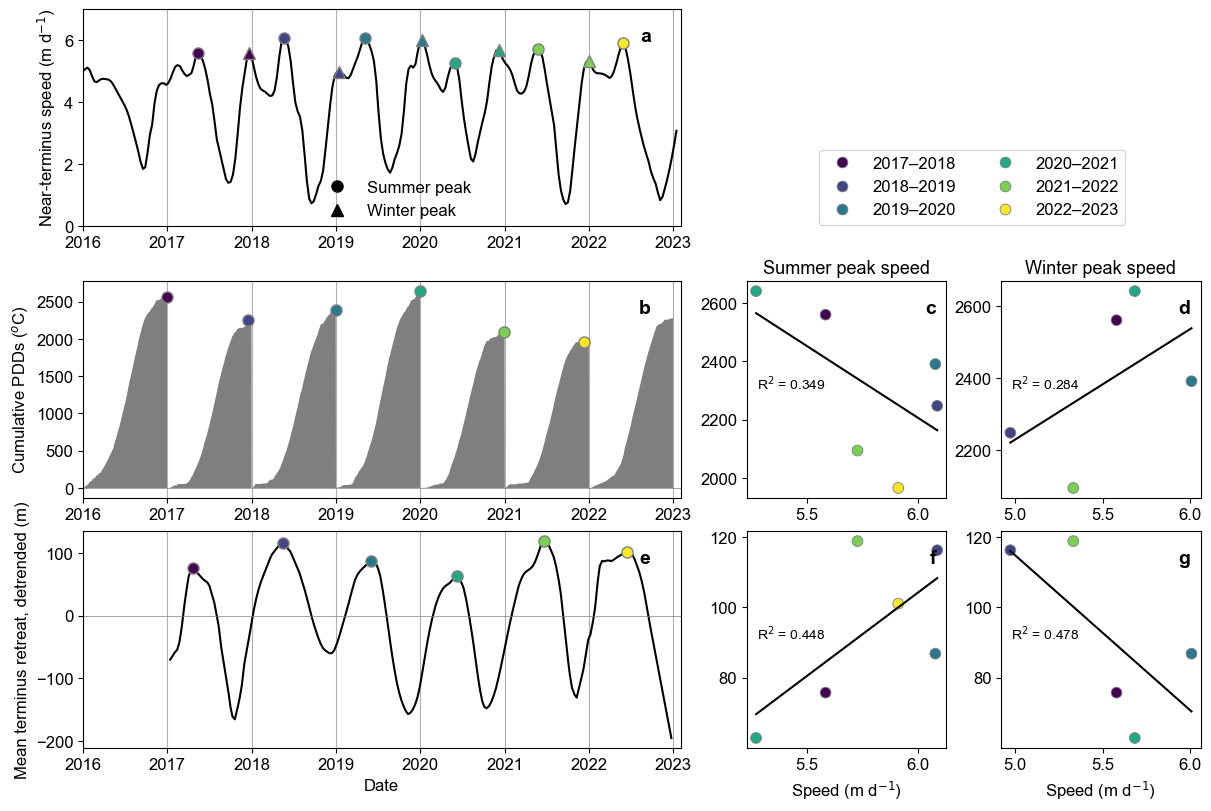

In [62]:
## Plot time series
fontsize=12
markersize=8
plt.rcParams.update({'font.sans-serif': 'Arial', 'font.size': fontsize})
fig, ax = plt.subplots(3, 3, figsize=(12,8), gridspec_kw={'width_ratios': [3,1,1]}, constrained_layout=True)

# -----Time series
# Speed
ax[0,0].plot(v_term['Date'], v_term['Mean'], '-k')
for date, summer_peak, color in v_summer_peaks[['Date', 'Mean', 'color']].values:
    ax[0,0].plot(date, summer_peak, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
for date, winter_peak, color in v_winter_peaks[['Date', 'Mean', 'color']].values:
    if date.year < 2022:
        ax[0,0].plot(date, winter_peak, '^', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[0,0].plot(np.datetime64('2000-01-01'), 0, 'o', color='k', markersize=markersize, label='Summer peak')
ax[0,0].plot(np.datetime64('2000-01-01'), 0, '^', color='k', markersize=markersize, label='Winter peak')
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False, bbox_to_anchor=[0.2, 0.6, 0.2, 0.2])
ax[0,0].set_ylim(0,7)
ax[0,0].set_ylabel('Near-terminus speed (m d$^{-1}$)')
# PDDs
ax[1,0].fill_between(air['Date'], np.zeros(len(air)), air['cumulative_PDD'], 
                     facecolor='k', edgecolor=None, alpha=0.5)
for date, pdd, color in pdd_peaks[['Date', 'cumulative_PDD', 'color']].values:
    ax[1,0].plot(date, pdd, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[1,0].set_ylabel('Cumulative PDDs ($^o$C)')
# Terminus
# ax[2,0].plot(term['Date'], term['Mean_retreat_m'], '-k', alpha=0.5)
ax[2,0].plot(term['Date'], term['Mean_retreat_detrended_m'], '-k')
for date, retreat, color in term_peaks[['Date', 'Mean_retreat_detrended_m', 'color']].values:
    ax[2,0].plot(date, retreat, 'o', markerfacecolor=color, markeredgecolor='gray', linewidth=0.5, markersize=markersize)
ax[2,0].set_ylabel('Mean terminus retreat, detrended (m)')
ax[2,0].set_xlabel('Date')
# adjust axes
xmin, xmax = np.datetime64('2016-01-01'), np.datetime64('2023-02-01')
for axis in ax[:,0]:
    axis.set_xlim(xmin, xmax)
    axis.xaxis.grid(True)
    axis.hlines(0, xmin, xmax, linewidth=0.5, color='grey')

# -----Peak regressions
def linear_fit(df):
    X, y = df.dropna().values[:,0], df.dropna().values[:,1]
    X = X.reshape(-1,1)
    lr = LinearRegression().fit(X,y)
    score = lr.score(X,y)
    Xpred = np.linspace(np.min(X), np.max(X), 100).reshape(-1,1)
    ypred = lr.predict(Xpred)
    return Xpred, ypred, score
def plot_score(axis, score):
    axis.text(0.05, 0.5, f'R$^2$ = {np.round(score,3)}', transform=axis.transAxes, ha='left', fontsize=fontsize-2)
    return
# PDD-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='cumulative_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', ax=ax[1,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'cumulative_PDD']])
ax[1,1].plot(Xpred, ypred, '-k')
plot_score(ax[1,1], score)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Summer peak speed', fontsize=fontsize+1)
# Add legend for years
handles, labels = ax[1,1].get_legend_handles_labels()
ax[1,1].legend().remove()
labels = ['2017–2018', '2018–2019', '2019–2020', '2020–2021', '2021–2022', '2022–2023']
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=[0.74, 0.63, 0.2, 0.2], ncols=2)
# PDD-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='cumulative_PDD', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[1,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'cumulative_PDD']])
ax[1,2].plot(Xpred, ypred, '-k')
plot_score(ax[1,2], score)
ax[1,2].set_xlabel('')
ax[1,2].set_ylabel('')
ax[1,2].set_title('Winter peak speed', fontsize=fontsize+1)
# Term-summer
sns.scatterplot(data=peaks_merged, x='Mean_summer_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,1]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_summer_peak', 'Mean_retreat_detrended_m']])
ax[2,1].plot(Xpred, ypred, '-k')
plot_score(ax[2,1], score)
ax[2,1].set_ylabel('')
ax[2,1].set_xlabel('Speed (m d$^{-1}$)')
# Term-winter
sns.scatterplot(data=peaks_merged, x='Mean_winter_peak', y='Mean_retreat_detrended_m', hue='fake_year', 
                palette=dict(peaks_merged[['fake_year', 'color']].values), s=60, edgecolor='gray', legend=False, ax=ax[2,2]) 
Xpred, ypred, score = linear_fit(peaks_merged[['Mean_winter_peak', 'Mean_retreat_detrended_m']])
ax[2,2].plot(Xpred, ypred, '-k')
plot_score(ax[2,2], score)
ax[2,2].set_ylabel('')
ax[2,2].set_xlabel('Speed (m d$^{-1}$)')

# Add panel labels
def plot_panel_label(axis, label):
    axis.text(0.95, 0.85, label, transform=axis.transAxes,
              ha='right', fontweight='bold', fontsize=fontsize+2)
    return
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
for axis, label in list(zip([ax[0,0], 
                             ax[1,0], ax[1,1], ax[1,2],
                             ax[2,0], ax[2,1], ax[2,2]], labels)):
    plot_panel_label(axis, label)

# Remove unused axes
ax[0,1].remove()
ax[0,2].remove()

# fig.tight_layout()
plt.show()

# Save figure
# fig_fn = os.path.join(out_path, 'speed_peaks_vs_PDD_terminus.png')
# fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
# print('Figure saved to file:', fig_fn)

<Axes: >

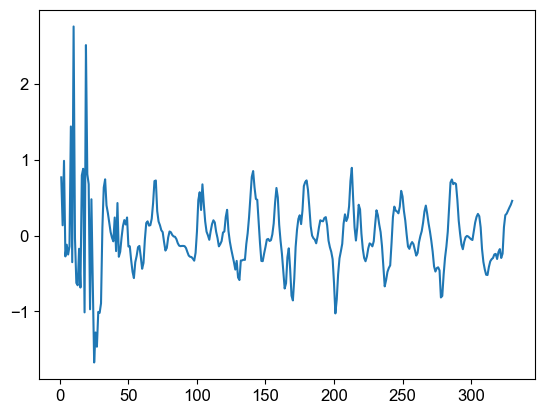

In [64]:
v_term['Mean'].diff().plot()